--- Inspecting Case 1 ---
Files in npz: ['image', 'mask', 'label', 'pixel_spacing', 'ac_reference', 'uuid']
Image shape: (80, 562, 744)
Mask shape: (80, 562, 744)
Label shape: (80,)
Pixel spacing: 0.28
Ground-truth AC (mm): 312.27002
--------------------
--- Inspecting Case 2 ---
Files in npz: ['image', 'mask', 'label', 'pixel_spacing', 'ac_reference', 'uuid']
Image shape: (80, 562, 744)
Mask shape: (80, 562, 744)
Label shape: (80,)
Pixel spacing: 0.28
Ground-truth AC (mm): 257.17072
--------------------
Frames with any annotation: 46 / 80
Optimal frames: 20
Suboptimal frames: 26
Unique masks [0 1 2]


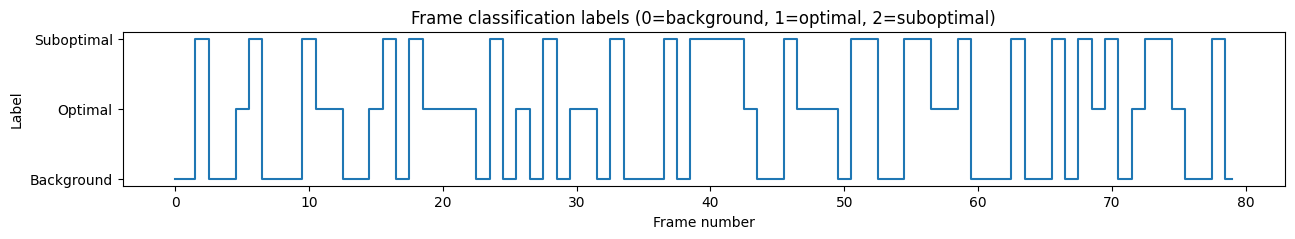

Visualizing the first 20 annotated frames out of 46...


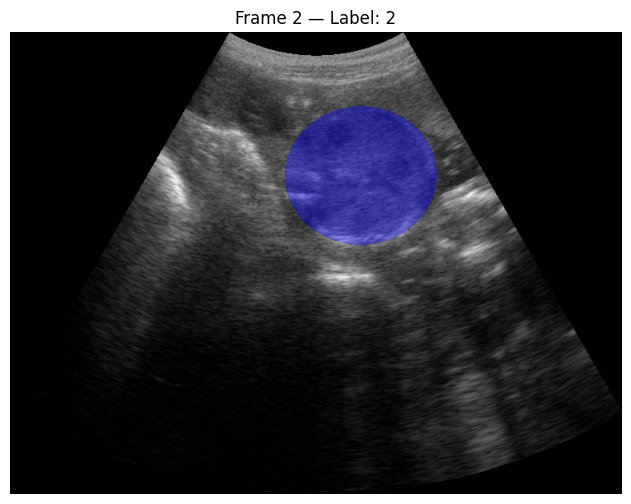

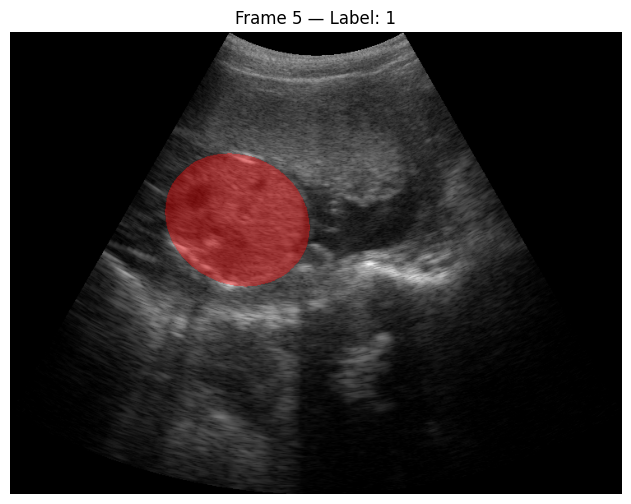

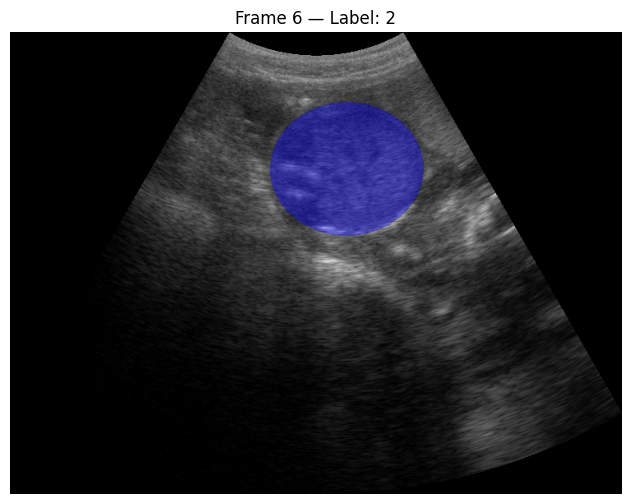

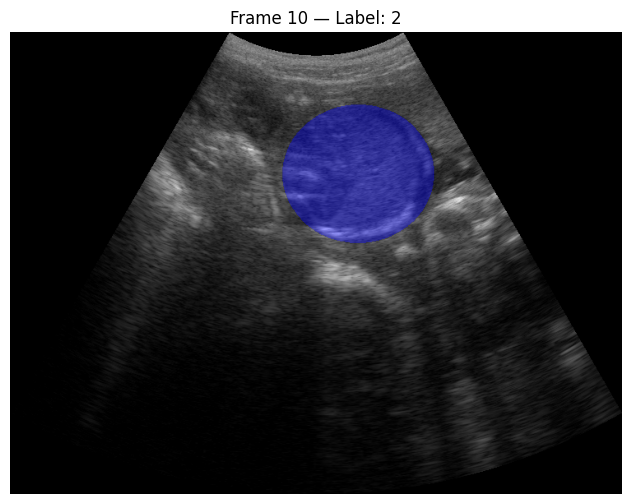

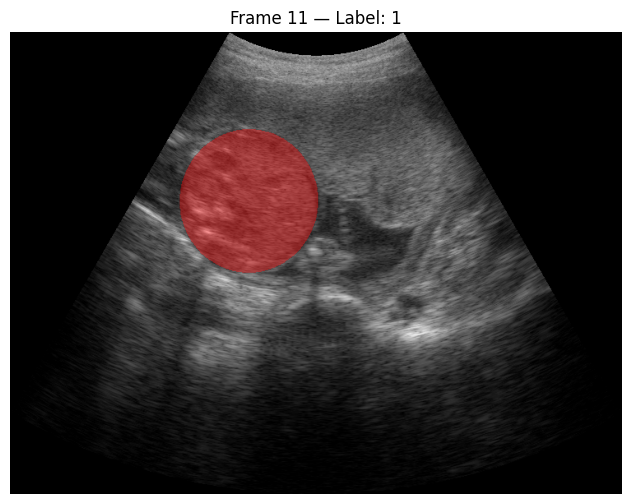

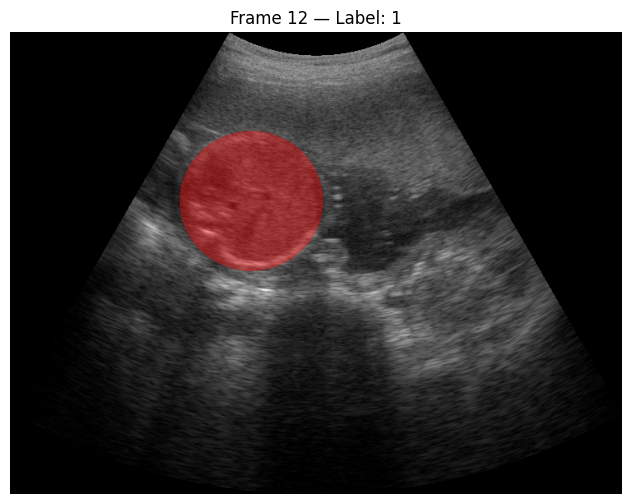

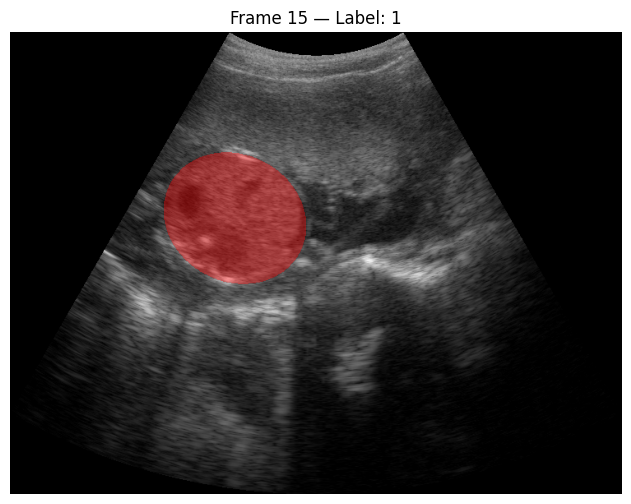

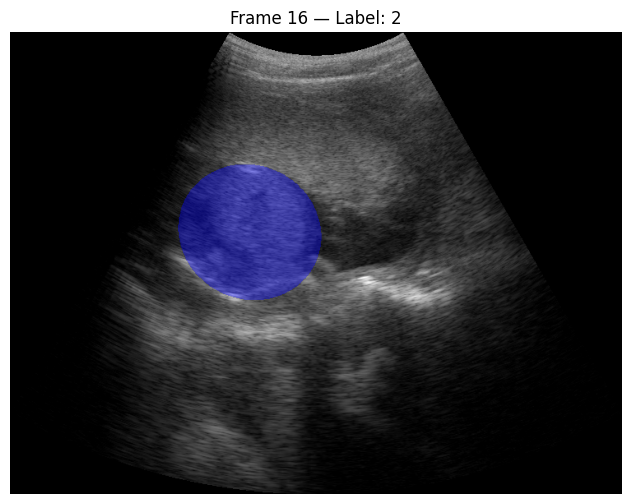

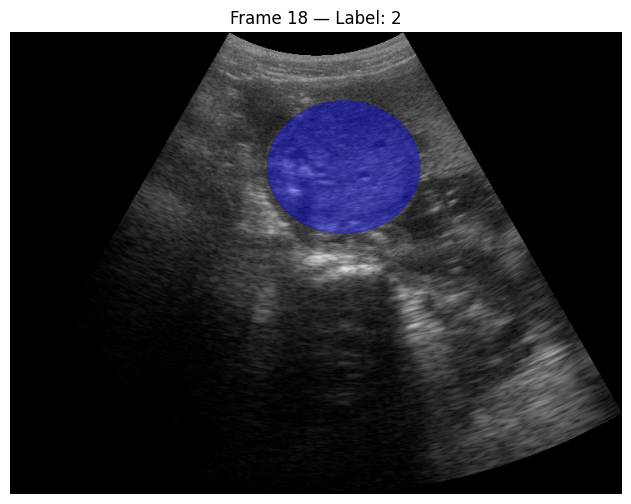

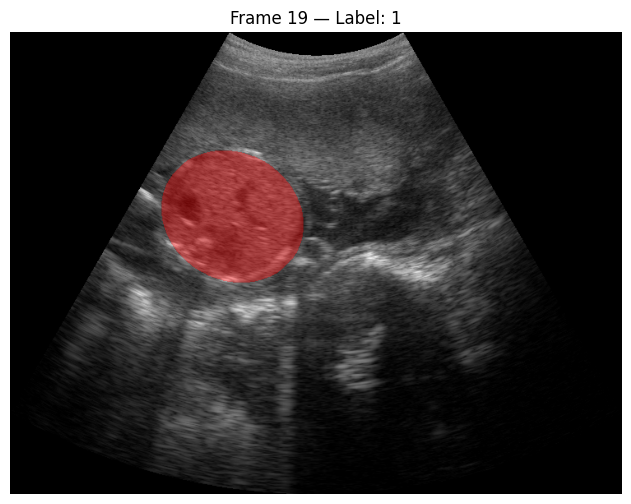

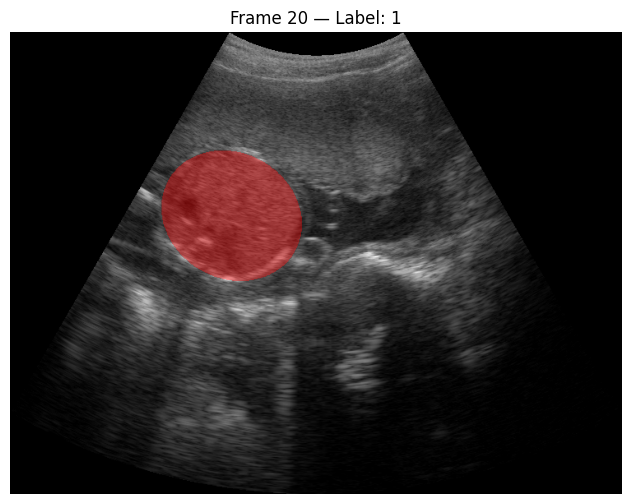

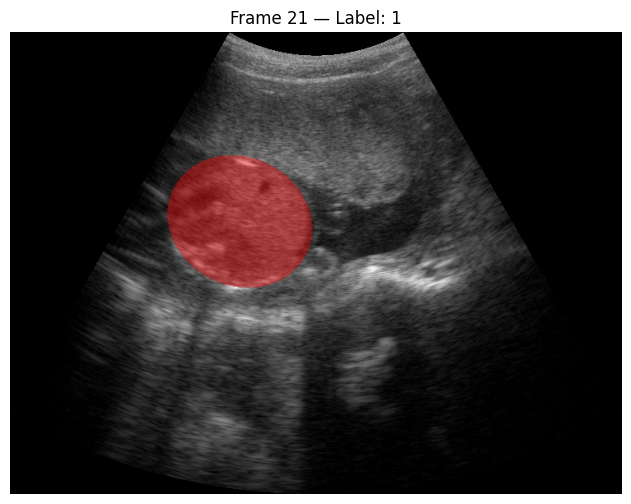

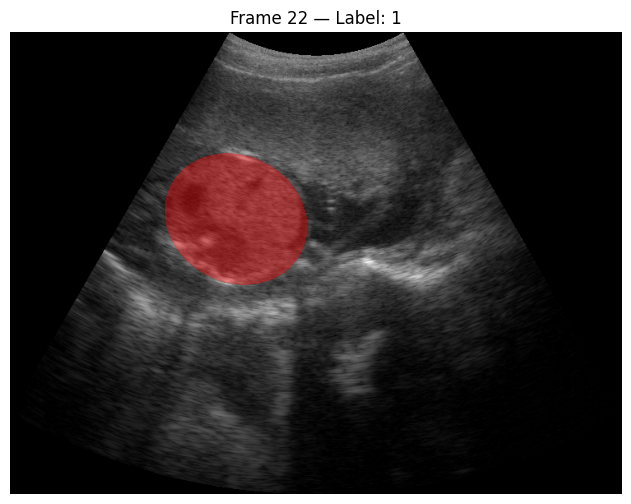

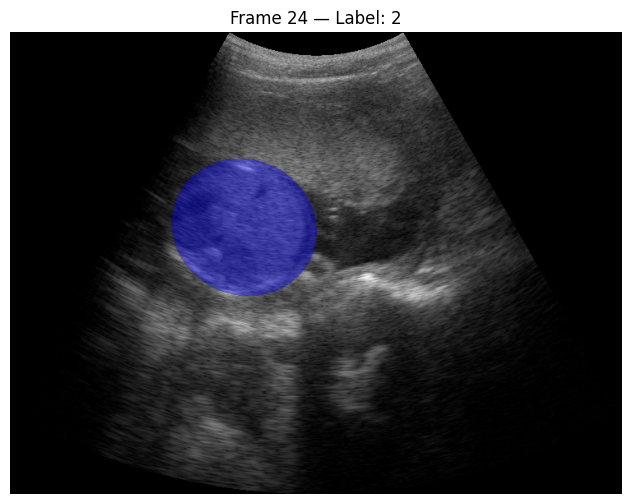

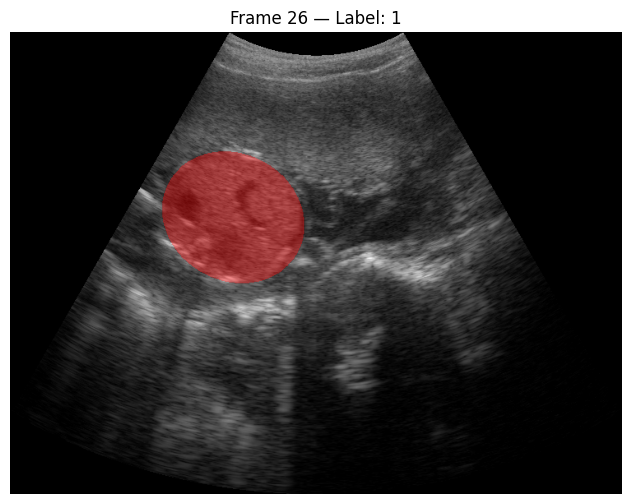

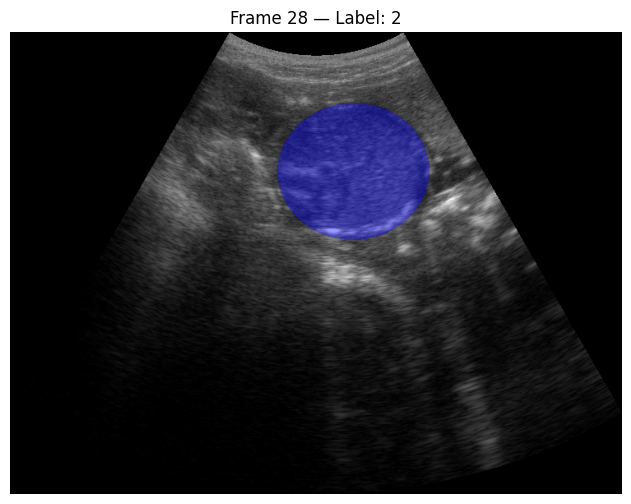

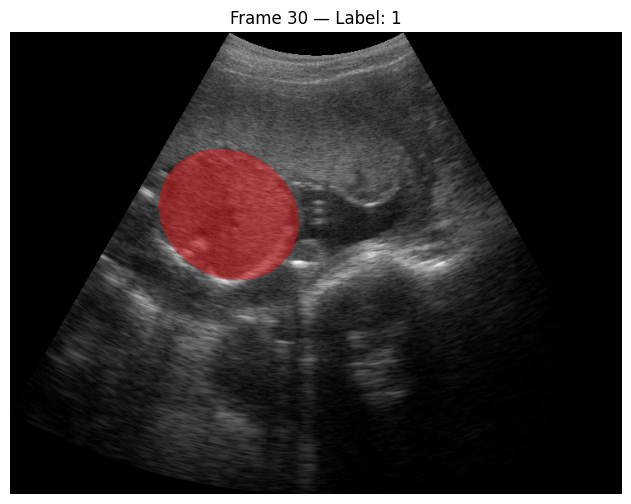

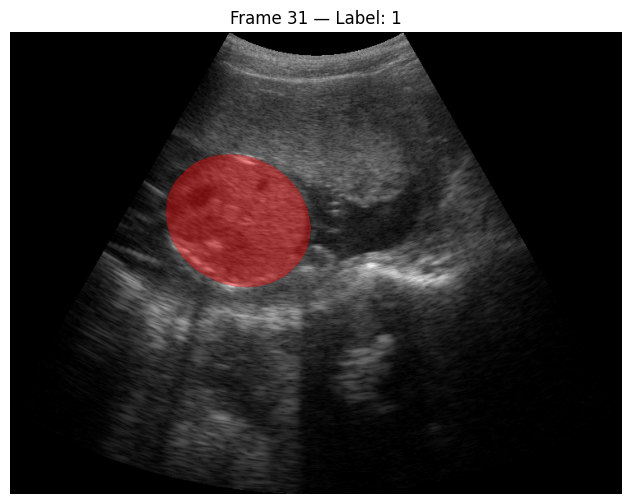

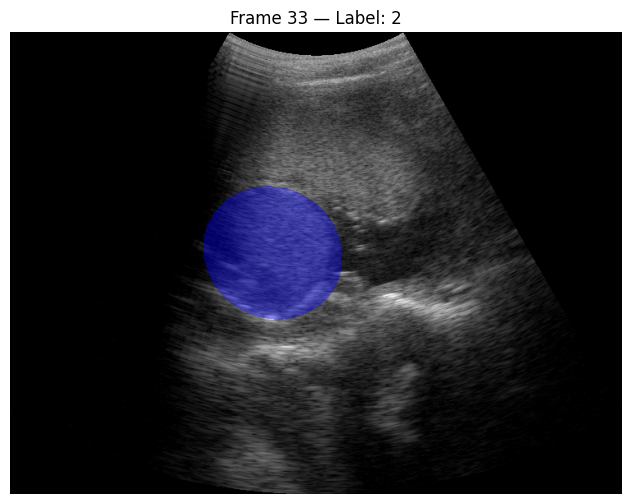

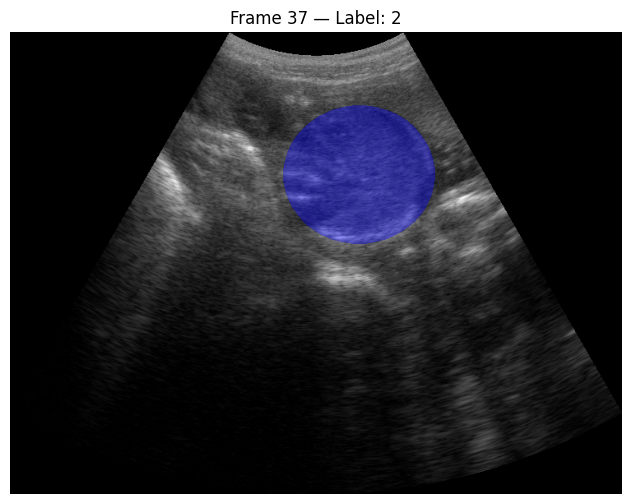

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Inspecting Multiple Cases ---
# This section loads and prints information for a few different files
# to quickly verify their contents.

print("--- Inspecting Case 1 ---")
case1 = np.load("D:/dataset/npz_80/0199616b-bdeb-4119-97a3-a5a3571bd641.npz")
print("Files in npz:", case1.files)
print("Image shape:", case1["image"].shape)
print("Mask shape:", case1["mask"].shape)
print("Label shape:", case1["label"].shape)
print("Pixel spacing:", case1["pixel_spacing"])
print("Ground-truth AC (mm):", case1["ac_reference"])
print("-" * 20)

print("--- Inspecting Case 2 ---")
case2 = np.load("D:/dataset/npz_80/02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1.npz")
print("Files in npz:", case2.files)
print("Image shape:", case2["image"].shape)
print("Mask shape:", case2["mask"].shape)
print("Label shape:", case2["label"].shape)
print("Pixel spacing:", case2["pixel_spacing"])
print("Ground-truth AC (mm):", case2["ac_reference"])
print("-" * 20)


# --- 2. Full Analysis of a Single Case ---
# This section focuses on a specific file for detailed analysis and visualization.

case = np.load("D:/dataset/npz_80/21127c13-cd7f-456b-ad07-71531d1cb054.npz")

images = case["image"]  # The video frames (e.g., [T, H, W] or [T, 1, H, W])
masks = case["mask"]    # The segmentation masks
labels = case["label"]  # The frame-level quality labels (0=none, 1=optimal, 2=suboptimal)



# --- 3. Print a Summary of Frames ---
print(f"Frames with any annotation: {(labels > 0).sum()} / {len(labels)}")
print(f"Optimal frames: {(labels == 1).sum()}")
print(f"Suboptimal frames: {(labels == 2).sum()}")
print(f"Unique masks {np.unique(masks)}")

# --- 4. Plot the Classification Labels Timeline ---
# This visualizes the label for each frame in the sequence.
plt.figure(figsize=(15, 2))
plt.title("Frame classification labels (0=background, 1=optimal, 2=suboptimal)")
plt.step(range(len(labels)), labels, where='mid')
plt.xlabel("Frame number")
plt.ylabel("Label")
plt.yticks([0, 1, 2], ['Background', 'Optimal', 'Suboptimal'])
plt.show()


# --- 5. Define a Visualization Function ---
# This function displays a single frame with its segmentation mask.
def show_frame_with_mask(frame_idx):
    """
    Displays a single video frame with its corresponding segmentation mask overlaid.
    """
    img = images[frame_idx]
    if img.ndim == 3:
        img = img[0]  # Remove channel dimension if present (e.g., from [1, H, W] to [H, W])

    mask = masks[frame_idx]
    if mask.ndim == 3:
        mask = mask[0]

    plt.figure(figsize=(8, 6))
    plt.title(f"Frame {frame_idx} — Label: {labels[frame_idx]}")
    plt.imshow(img, cmap='gray')

    # Create an RGBA overlay for the mask
    mask_overlay = np.zeros((*mask.shape, 4))
    
    # Red overlay for optimal frames (label 1)
    mask_overlay[mask == 1] = [1, 0, 0, 0.4]
    
    # Blue overlay for suboptimal frames (label 2)
    mask_overlay[mask == 2] = [0, 0, 1, 0.4]

    plt.imshow(mask_overlay)
    plt.axis("off")
    plt.show()


# --- 6. Visualize Annotated Frames ---
# This section finds all frames with a label of 1 or 2 and visualizes the first 20.
annotated_frames = np.where((labels == 1) | (labels == 2))[0]
print(f"Visualizing the first 20 annotated frames out of {len(annotated_frames)}...")

for idx in annotated_frames[:20]:
    show_frame_with_mask(idx)

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.transforms as T

class NPZFrameDataset(Dataset):
    def __init__(self, npz_dir, files, transform=None):
        self.samples = []
        self.transform = transform

        for f in files:
            case = np.load(os.path.join(npz_dir, f))
            images = case["image"].astype(np.float32)   # (F,H,W)
            labels = case["label"].astype(np.int64)     # (F,)

            # normalize [0,1]
            images = (images - images.min()) / (images.max() - images.min() + 1e-8)
            labels[labels == 2] = 1   # remap

            # flatten into (frame, label)
            for img, lbl in zip(images, labels):
                self.samples.append((img, lbl))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, lbl = self.samples[idx]

        # (H,W) → (1,H,W)
        img = torch.tensor(img).unsqueeze(0)

        # resize to (1,224,224)
        img = F.interpolate(img.unsqueeze(0),
                            size=(224, 224),
                            mode="bilinear",
                            align_corners=False).squeeze(0)

        if self.transform is not None:
            img = self.transform(img)   # expects Tensor → augmentations

        return img, torch.tensor(lbl).long()


In [2]:
import torchvision.models as models
import torch.nn as nn

class FrameClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        # change first conv → grayscale
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):   # (B,1,H,W)
        return self.backbone(x)


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tqdm import tqdm

In [4]:
# ==== Dataset with Augmentation ====

train_transform = T.Compose([
    # --- Geometric ---
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomRotation(degrees=15),
    T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),

    # --- Photometric ---
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
    T.RandomApply([T.GaussianBlur(kernel_size=5)], p=0.1),
    T.RandomAdjustSharpness(sharpness_factor=2, p=0.3),

    # --- Occlusion / noise (tensor ops) ---
    T.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0),
    T.RandomApply([T.Lambda(lambda x: (x + 0.05*torch.randn_like(x)).clamp(0, 1))], p=0.2),

    # --- Final (no ToTensor here) ---
    T.Normalize(mean=[0.5], std=[0.5])  # for 1-channel tensors in [0,1]
])

val_transform = T.Compose([
    T.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = NPZFrameDataset("D:/dataset/npz_80", 
                                sorted(os.listdir("D:/dataset/npz_80"))[:210], 
                                transform=train_transform)
val_dataset = NPZFrameDataset("D:/dataset/npz_80", 
                            sorted(os.listdir("D:/dataset/npz_80"))[210:255], 
                            transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FrameClassifier(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # weight decay added
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

c:\Users\User\anaconda3\envs\torch310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\torch310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# best_acc = 0.0
# patience = 5
# no_improve = 0
# save_path = "D:/acouslic-ai-cse4622/saved_weights/best_frame_classifier.pth"

# for epoch in range(20):  # allow more epochs, early stopping will cut off
#     # ---- Training ----
#     model.train()
#     loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
#     total_loss = 0
#     for images, labels in loop:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         loop.set_postfix(loss=loss.item())

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f}")

#     # ---- Validation ----
#     model.eval()
#     correct, total = 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             preds = outputs.argmax(1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     val_acc = 100 * correct / total
#     print(f"Val Acc: {val_acc:.2f}%")

#     # ---- Scheduler Step ----
#     scheduler.step(val_acc)

#     # ---- Early Stopping & Checkpoint ----
#     if val_acc > best_acc:
#         best_acc = val_acc
#         no_improve = 0
#         torch.save(model.state_dict(), save_path)
#         print(f"✅ Best model saved with val acc = {best_acc:.2f}%")
#     else:
#         no_improve += 1
#         if no_improve >= patience:
#             print("⏹️ Early stopping triggered.")
#             break

# print(f"Training finished. Best validation accuracy = {best_acc:.2f}%")

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
model = FrameClassifier(num_classes=2).to(device)
model.load_state_dict(torch.load("D:/acouslic-ai-cse4622/saved_weights/best_frame_classifier.pth", 
                                 map_location=device))
model.eval()

# --- Preprocessing (must match training pipeline!) ---
inference_transform =T.Compose([

    # --- Final (no ToTensor here) ---
    T.Normalize(mean=[0.5], std=[0.5])  # for 1-channel tensors in [0,1]
])

def pick_best_frame(npz_path, batch_size=64):
    case = np.load(npz_path, mmap_mode="r")   # lazy access
    images = case["image"]   # (F, H, W)

    best_idx, best_score = None, -1.0

    # process in batches
    for start in range(0, len(images), batch_size):
        batch = images[start:start+batch_size].astype(np.float32)
        batch = (batch - batch.min()) / (batch.max() - batch.min() + 1e-8)  # normalize

        # (B,1,H,W) → resize to 224
        batch_tensor = torch.tensor(batch).unsqueeze(1)   # (B,1,H,W)
        batch_tensor = F.interpolate(batch_tensor, size=(224,224),
                                     mode="bilinear", align_corners=False)
        batch_tensor = (batch_tensor - 0.5) / 0.5  # match Normalize(mean=0.5, std=0.5)
        batch_tensor = batch_tensor.to(device)

        with torch.no_grad():
            logits = model(batch_tensor)
            probs = torch.softmax(logits, dim=1)[:,1]  # (B,)

        max_prob, max_idx = torch.max(probs, dim=0)
        if max_prob.item() > best_score:
            best_score = max_prob.item()
            best_idx = start + max_idx.item()

    return best_idx, best_score


# --- Example usage ---
npz_path = "D:/dataset/npz_80/21127c13-cd7f-456b-ad07-71531d1cb054.npz"
best_idx, best_prob = pick_best_frame(npz_path)
print(f"Best frame = {best_idx}, Probability = {best_prob:.4f}")

Best frame = 15, Probability = 0.9304


In [7]:
import os, random, numpy as np
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(1337)

# ---- Your existing model loading here ----
model = FrameClassifier(num_classes=2).to(device)
model.load_state_dict(torch.load("D:/acouslic-ai-cse4622/saved_weights/best_frame_classifier.pth", map_location=device))
model.eval()

def pick_best_frame(npz_path, batch_size=64):
    case = np.load(npz_path, mmap_mode="r")   # lazy access
    images = case["image"]   # (F, H, W)

    best_idx, best_score = None, -1.0

    for start in range(0, len(images), batch_size):
        batch = images[start:start+batch_size].astype(np.float32)  # (B, H, W)

        # ---- per-frame min-max normalization to [0,1] ----
        b = torch.from_numpy(batch)                               # (B,H,W)
        b = b.unsqueeze(1)                                        # (B,1,H,W)
        b_min = b.amin(dim=(2,3), keepdim=True)
        b_max = b.amax(dim=(2,3), keepdim=True)
        b = (b - b_min) / (b_max - b_min + 1e-8)

        # ---- resize & training-normalize ([0,1] -> [-1,1]) ----
        b = F.interpolate(b, size=(224, 224), mode="bilinear", align_corners=False)
        b = (b - 0.5) / 0.5                                       # mean=0.5, std=0.5
        b = b.to(device)

        with torch.no_grad():
            logits = model(b)
            probs = torch.softmax(logits, dim=1)[:, 1]            # (B,)

        # track best (global) index & score
        max_prob, max_idx = torch.max(probs, dim=0)
        if max_prob.item() > best_score:
            best_score = max_prob.item()
            best_idx = start + max_idx.item()

    return best_idx, best_score


def get_label_array(case_npz):
    """
    Try to locate per-frame labels in the NPZ.
    Common keys tried in order: 'label', 'labels', 'y', 'gt', 'target'.
    Returns a 1D numpy array of shape (F,) with 0/1 values.
    Raises KeyError if not found.
    """
    for key in ["label", "labels", "y", "gt", "target"]:
        if key in case_npz:
            arr = case_npz[key]
            # Squeeze possible extra dims, ensure 1D
            arr = np.asarray(arr)
            return arr.reshape(-1)
    raise KeyError("No per-frame label key found (tried: label, labels, y, gt, target).")


def evaluate_random_subset(root_dir="D:/dataset/npz_80", start_idx=255, k=12):
    files = sorted([f for f in os.listdir(root_dir) if f.endswith(".npz")])
    test_files = files[start_idx:]
    if len(test_files) == 0:
        raise RuntimeError("No files found at or after index 255.")
    sample = random.sample(test_files, k=min(k, len(test_files)))

    total = 0
    hits_anypos = 0          # predicted index falls on any positive frame
    exact_argmax_hits = 0    # predicted index equals argmax label (if multiple 1s, first one)
    mean_prob_accum = []
    dist_to_nearest_pos = [] # distance (frames) to the nearest positive; 0 means exact match

    print(f"Evaluating {len(sample)} files...\n")

    for fname in sample:
        path = os.path.join(root_dir, fname)
        case = np.load(path, mmap_mode="r")
        labels = get_label_array(case)  # (F,)
        positives = np.where((labels == 1) | (labels == 2))[0]

        pred_idx, pred_prob = pick_best_frame(path)
        total += 1
        mean_prob_accum.append(pred_prob)

        # metrics
        anypos = (pred_idx in positives) if positives.size > 0 else (labels[pred_idx] == 0 and positives.size == 0)
        hits_anypos += int(anypos)

        # argmax match (falls back to first positive if multiple)
        if positives.size > 0:
            gt_argmax = positives[0]
        else:
            gt_argmax = int(np.argmax(labels))  # all zeros → 0

        exact_argmax_hits += int(pred_idx == gt_argmax)

        if positives.size > 0:
            dist = int(np.min(np.abs(positives - pred_idx)))
        else:
            dist = 0  # define 0 when no positives exist
        dist_to_nearest_pos.append(dist)

        print(f"{fname}")
        print(f"  Frames: {len(labels)} | Pred idx: {pred_idx:4d} (p={pred_prob:.4f})")
        if positives.size > 0:
            print(f"  GT positives: {positives.tolist()[:12]}{' ...' if len(positives)>12 else ''}")
        else:
            print("  GT positives: []")
        print(f"  Hit any positive? {'YES' if anypos else 'NO'} | Dist→nearest +ve: {dist}\n")

    acc_anypos = hits_anypos / total
    acc_exact  = exact_argmax_hits / total
    mean_prob  = float(np.mean(mean_prob_accum))
    mean_dist  = float(np.mean(dist_to_nearest_pos))

    print("====== Summary ======")
    print(f"Files evaluated:      {total}")
    print(f"Hit any positive:     {hits_anypos}/{total}  ({acc_anypos*100:.1f}%)")
    print(f"Exact argmax matches: {exact_argmax_hits}/{total}  ({acc_exact*100:.1f}%)")
    print(f"Mean predicted prob:  {mean_prob:.4f}")
    print(f"Mean dist to +ve:     {mean_dist:.2f} frames")
    print("=====================")


# ---- Run evaluation on 10–12 random files from index >=255 ----
evaluate_random_subset(
    root_dir="D:/dataset/mult_mha_to_npz",
    start_idx=255,
    k=45 # choose 10–12 as you prefer
)


Evaluating 45 files...

f8039e25-4652-440c-9476-b425f3fccb22.npz
  Frames: 840 | Pred idx:   56 (p=0.9662)
  GT positives: [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63] ...
  Hit any positive? YES | Dist→nearest +ve: 0

f4bebd1e-d3ca-4186-902a-2b6ef9391060.npz
  Frames: 840 | Pred idx:   41 (p=0.9889)
  GT positives: [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] ...
  Hit any positive? YES | Dist→nearest +ve: 0

e9043ff5-f8a4-4095-bc44-26232e1be011.npz
  Frames: 840 | Pred idx:   18 (p=0.9887)
  GT positives: [13, 14, 15, 16, 17, 18, 140, 141, 142]
  Hit any positive? YES | Dist→nearest +ve: 0

f5a702f0-d759-4b53-8215-462e8145e638.npz
  Frames: 840 | Pred idx:  280 (p=0.8867)
  GT positives: [30, 31, 32, 33, 34, 164, 165, 166, 167, 168, 169, 170] ...
  Hit any positive? NO | Dist→nearest +ve: 21

f5e853b1-9465-40b0-a246-7d3f6cb94de7.npz
  Frames: 840 | Pred idx:  474 (p=0.9582)
  GT positives: [4, 5, 6, 7, 8, 9, 10, 44, 45, 46, 47, 157] ...
  Hit any positive? YES | Dist→nearest 

In [10]:
! pip install pandas

In [ ]:
import pandas as pd
df = pd.read_csv("D:/acouslic-ai-cse4622/dataset_audit.csv")
total = df["frames_with_mask"].sum()
print(total)


6620
